# Introduction

Diabetic Retinopathy (DR) is a complication of diabetes, caused by high blood sugar levels damaging the back of the eye (retina). It can cause blindness if left undiagnosed and untreated.

DR is split:
- Grade 0 and 1: considered as No "referable" DR, because 1 is difficult to diagnose (early DR)
- Grade 2: **background retinopathy** – tiny bulges develop in the blood vessels, which may bleed slightly but do not usually affect your vision
- Grade 3:**pre-proliferative retinopathy** – more severe and widespread changes affect the blood vessels, including more significant bleeding into the eye
- Grade 4: **proliferative retinopathy** – scar tissue and new blood vessels, which are weak and bleed easily, develop on the retina; this can result in some loss of vision

*Source: [NHS UK](https://www.nhs.uk/conditions/diabetic-retinopathy/)*

Globally, the number of people with DR will grow from 126.6 million in 2010 to 191.0 million by 2030.  
*Source: [10.4103/0301-4738.100542](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491270/)*

![dr_grades.png](https://www.ophthalytics.com/wp-content/uploads/2021/08/Copy-of-WEBSITE-CONTENT-1536x878.png)

**Source:** Ophthalytics.  
**Link:** https://www.ophthalytics.com/our-technology/diabetic-retinopathy/

Note we will refer to Diabetic Retinoptahy as DR in the following.

With:
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR

## Credits

This [implementation](https://www.kaggle.com/code/raufmomin/vision-transformer-vit-fine-tuning) was taken from [RAUF MOMIN](https://www.kaggle.com/raufmomin). 

## Disclaimer
This notebook implements Vision Transformer (ViT) model by Alexey Dosovitskiy et al for image classification, and demonstrates it on the APTOS 2019 Diabetic Retionapathy Classification dataset.

For from scratch implementation of ViT check out this notebook: <br>
https://www.kaggle.com/raufmomin/vision-transformer-vit-from-scratch

Research Paper: https://arxiv.org/pdf/2010.11929.pdf <br>
Github (Official) Link: https://github.com/google-research/vision_transformer <br>
Github (Keras) Link: https://github.com/faustomorales/vit-keras

#### Highlights of this notebook:
1. Pre-trained Vision Transformer (vit_b32) on imagenet21k dataset
2. Label Smoothing of 0.3
3. Custom data augmentation for ImageDataGenerator
4. RectifiedAdam Optimizer
5. Grad CAM

# ViT Architecture

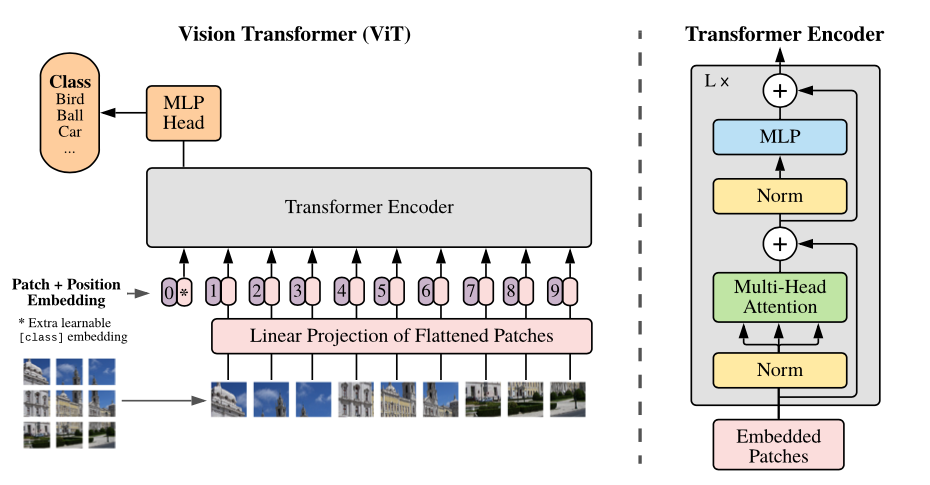

# Libraries and Configurations

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images'
TEST_PATH = '../input/aptos2019-blindness-detection/test_images'

DF_TRAIN = pd.read_csv('../input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN['image_path'] = DF_TRAIN["id_code"] + ".png" 
TEST_IMAGES = glob.glob(TEST_PATH + '/*.png')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

classes = {0 : "No DR",
           1 : "Mild",
           2 : "Moderate",
           3 : "Severe",
           4 : "Proliferative"}

In [6]:
DF_TRAIN.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [7]:
DF_TEST.head()

,image_path
0,../input/aptos2019-blindness-detection/test_im...
1,../input/aptos2019-blindness-detection/test_im...
2,../input/aptos2019-blindness-detection/test_im...
3,../input/aptos2019-blindness-detection/test_im...
4,../input/aptos2019-blindness-detection/test_im...


# Data Augmentations

In [13]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    #p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    #if p_rotate > .75:
        #image = tf.image.rot90(image, k = 3) # rotate 270º
    #elif p_rotate > .5:
        #image = tf.image.rot90(image, k = 2) # rotate 180º
    #elif p_rotate > .25:
        #image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

# Data Generator

In [14]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_path',
                                        y_col = 'diagnosis',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'image_path',
                                        y_col = 'diagnosis',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


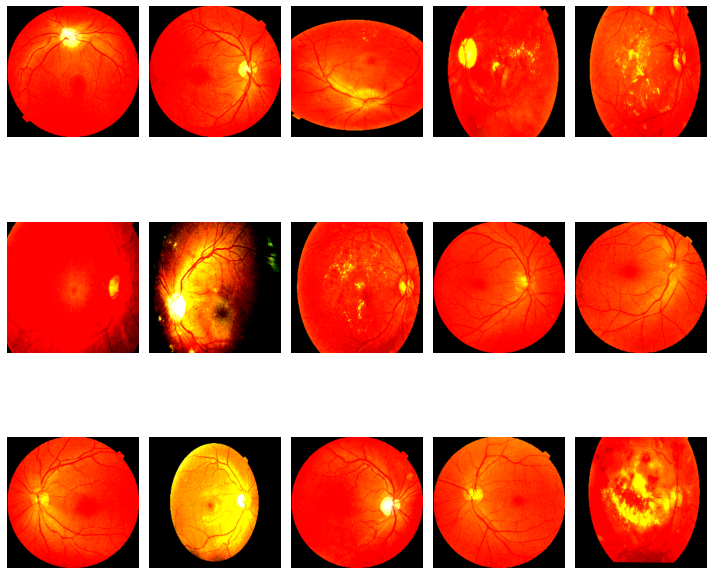

In [15]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Model

In [16]:
!pip install --quiet vit-keras

from vit_keras import vit

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 1. ViT B32 Model

In [17]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

353255424/353253686 [==============================] - 59s 0us/step


### Visualizing Attention Maps of Sample Test Image

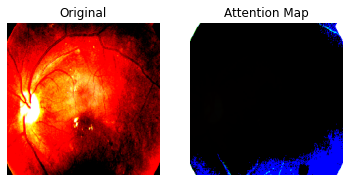

In [18]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## 2. Fine-tuning the Model

In [19]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 60        
Total params: 87,466,867
Trainable params: 87,465,309
Non-trainable params: 1,558
________________________________

In [77]:
model_b = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model_b.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
layer_normalization (LayerNo (None, 768)               1536      
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11)                44        
_________________________________________________________________
dense_3 (Dense)              (None, 5)          

# Training the Model

In [20]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

#model.save('model.h5', save_weights_only = True) #NO NEED AS THE WEIGHTS ARE ALREADY SAVED

Epoch 1/7
183/183 [==============================] - 1157s 6s/step - loss: 1.7917 - accuracy: 0.3765 - val_loss: 1.3220 - val_accuracy: 0.6792

Epoch 00001: val_accuracy improved from -inf to 0.67917, saving model to ./model.hdf5
Epoch 2/7
183/183 [==============================] - 1099s 6s/step - loss: 1.2129 - accuracy: 0.6669 - val_loss: 1.3682 - val_accuracy: 0.6611

Epoch 00002: val_accuracy did not improve from 0.67917
Epoch 3/7
183/183 [==============================] - 1068s 6s/step - loss: 1.1460 - accuracy: 0.7294 - val_loss: 1.1512 - val_accuracy: 0.7431

Epoch 00003: val_accuracy improved from 0.67917 to 0.74306, saving model to ./model.hdf5
Epoch 4/7
183/183 [==============================] - 1052s 6s/step - loss: 1.1401 - accuracy: 0.7225 - val_loss: 1.2206 - val_accuracy: 0.7208

Epoch 00004: val_accuracy did not improve from 0.74306
Epoch 5/7
183/183 [==============================] - 1056s 6s/step - loss: 1.1063 - accuracy: 0.7454 - val_loss: 1.2666 - val_accuracy: 0.7

TypeError: save() got an unexpected keyword argument 'save_weights_only'

In [41]:
model.load_weights("./model.hdf5")

In [42]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87455232  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 11)                8459      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 60        
Total params: 87,466,867
Trainable params: 87,465,309
Non-trainable params: 1,558
________________________________

In [54]:
model.get_layer("vit-b32").summary()

Model: "vit-b32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
embedding (Conv2D)           (None, 7, 7, 768)         2360064   
_________________________________________________________________
reshape (Reshape)            (None, 49, 768)           0         
_________________________________________________________________
class_token (ClassToken)     (None, 50, 768)           768       
_________________________________________________________________
Transformer/posembed_input ( (None, 50, 768)           38400     
_________________________________________________________________
Transformer/encoderblock_0 ( ((None, 50, 768), (None,  7087872   
_________________________________________________________________
Transformer/encoderblock_1 ( ((None, 50, 768), (None,  7087

# Model Results

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       337
           1       0.52      0.68      0.59        77
           2       0.71      0.72      0.72       221
           3       0.45      0.34      0.39        38
           4       0.61      0.32      0.42        59

    accuracy                           0.78       732
   macro avg       0.65      0.61      0.61       732
weighted avg       0.78      0.78      0.77       732



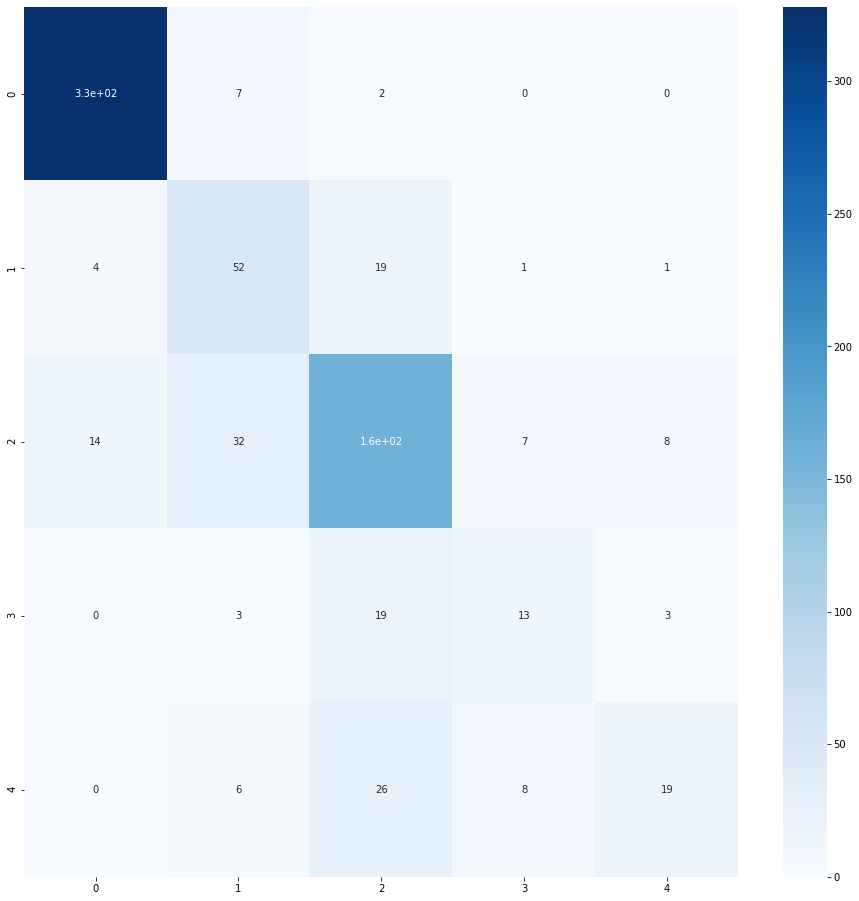

In [21]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

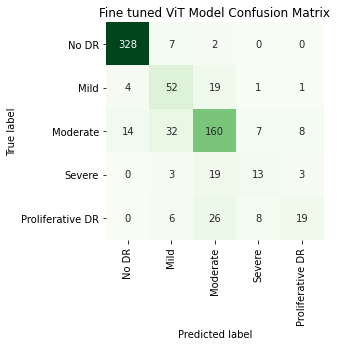

In [28]:
# Creates a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"], 
                     columns = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, square=True, annot=True, cmap="Greens", fmt='d', cbar=False)
plt.title('Fine tuned ViT Model Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Investigate Model's Predictions

## Grad CAM Algorithm

Source: https://www.kaggle.com/code/easara/covid19-detection-with-vit-and-heatmap/edit

In [71]:
def get_img_array(img):
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [72]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output#[0]
    #print(np.expand_dims(last_conv_layer_output,axis=0))
    #print(pooled_grads[..., tf.newaxis])
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [73]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4,preds=[0,0,0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    #plt.figure(figsize=(8,8))
    plot.imshow(superimposed_img)
    plot.set(title =
        "No DR: \
        {:.3f}\nMild: \
        {:.3f}\nModerate: \
        {:.3f}\nSevere: \
        {:.3f}\nProliferative: \
        {:.3f}".format(preds[0], \
                    preds[1], \
                    preds[2], \
                    preds[3],
                    preds[4])
    )
    plot.axis('off')

In [79]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

test_image = next(iter(valid_gen))[0][5]
# Prepare image
img_array = get_img_array(test_image)

last_conv_layer_name = 'layer_normalization'
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:\n" +"No DR: \
    {p1}\nMild: {p2}\nModerate: \
    {p3}\nSevere: \
    {p4} \nProliferative: {p5}".format(p1=preds[0][0], \
                                            p2=preds[0][1],p3=preds[0][2],p4=preds[0][3],p5=preds[0][4]))
# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
# Display heatmap
plt.matshow(heatmap)

plt.show()

Predicted:
No DR:     -1.3018912076950073
Mild: 0.7394576072692871
Moderate:     1.3603233098983765
Severe:     -0.9317346215248108 
Proliferative: -1.2237292528152466


ValueError: No such layer: layer_normalization.

In [33]:
filenames_path = valid_gen.filenames

index_diff, index_same = [], []
for i, t, p in zip(range(len(true_classes)), true_classes, predicted_classes):
    if  t != p:
        index_diff.append(i)
    else:
        index_same.append(i)
        
predictions = [int(p.item(0)) for p in predicted_classes]
filenamepath_diff = [filenames_path[i] for i in index_diff]
ground_truth_diff = [true_classes[i] for i in index_diff]
predictions_diff = [predictions[i] for i in index_diff]
diff_pred_df = {"Ground_Truth": ground_truth_diff,
                 "Prediction": predictions_diff,
                 "Filename_Path": filenamepath_diff}
df_diff = pd.DataFrame(diff_pred_df)
df_diff.to_csv("vitB32_finetuned_failures.csv")

filenamepath_same = [filenames_path[i] for i in index_same]
ground_truth_same = [true_classes[i] for i in index_same]
predictions_same = [predictions[i] for i in index_same]
same_pred_df = {"Ground_Truth": ground_truth_same,
                 "Prediction": predictions_same,
                 "Filename_Path": filenamepath_same}
df_same = pd.DataFrame(same_pred_df)
df_same.to_csv("vitB32_finetuned_successes.csv") 

In [34]:
# The model made ~22% errors over the val set
df_diff.shape, df_same.shape

((160, 3), (572, 3))

In [36]:
df_diff.head()

,Ground_Truth,Prediction,Filename_Path
0,2,1,00e4ddff966a.png
1,2,4,01c7808d901d.png
2,2,1,01eb826f6467.png
3,4,2,0243404e8a00.png
4,2,0,025a169a0bb0.png


In [37]:
df_same.head()

,Ground_Truth,Prediction,Filename_Path
0,2,2,000c1434d8d7.png
1,4,4,001639a390f0.png
2,1,1,0024cdab0c1e.png
3,0,0,002c21358ce6.png
4,0,0,005b95c28852.png


## Example of the model's failure

The class with the most failures is Moderate being considered as Mild (34 misclassifications) 

In [39]:
Moderate = df_diff[df_diff["Ground_Truth"] == 2]
# 2:Moderate confused with 0: no DR and 1: Mild
Moderate[(Moderate["Prediction"] == 0) | (Moderate["Prediction"] == 1)].head(10)

,Ground_Truth,Prediction,Filename_Path
0,2,1,00e4ddff966a.png
2,2,1,01eb826f6467.png
4,2,0,025a169a0bb0.png
8,2,1,032d7b0b4bf6.png
10,2,0,03676c71ed1b.png
23,2,1,094858f005ab.png
28,2,0,0c2e2369dfff.png
32,2,1,0d0a21fd354f.png
34,2,0,0e75d51152fc.png
41,2,1,0fffa73e2402.png


In [40]:
Moderate.reset_index(drop=True, inplace=True)
Moderate.head(-2)

,Ground_Truth,Prediction,Filename_Path
0,2,1,00e4ddff966a.png
1,2,4,01c7808d901d.png
2,2,1,01eb826f6467.png
3,2,0,025a169a0bb0.png
4,2,1,032d7b0b4bf6.png
5,2,0,03676c71ed1b.png
6,2,4,03747397839f.png
7,2,4,03fd50da928d.png
8,2,3,07a3be30563b.png
9,2,1,094858f005ab.png


# Resources

For more details, check :
- [Paper](https://arxiv.org/pdf/2010.11929.pdf)
- [Implement ViT from scratch version](https://www.kaggle.com/code/basu369victor/covid19-detection-with-vit-and-heatmap) : easier to implement Grad CAM with, as you can directly access Layer Normalization
- Check out the [Hybrid-Effcient-SwinTransfomer version](https://github.com/elateifsara/devoxxMA22/blob/main/devoxxma22-inspect-your-model.ipynb)